# Liveify Model Testing
Load trained model and visualize results on validation data.

In [1]:
import sys
import os
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Audio

sys.path.insert(0, '../')

from train import LiveifyLightningModule
from model import LiveifyModel
from dataset_utils.dataset import StudioLiveDataModule

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Using device: cuda


## Load Model and Data

In [2]:
CHECKPOINT_PATH = "../../checkpoints/best-v12.ckpt"
SAMPLE_RATE = 22050
SEGMENT_DURATION = 0.5
CONTEXT_LENGTH = 64
PATCH_SIZE = 16

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
state_dict = checkpoint['state_dict']

pos_embed_keys = [k for k in state_dict.keys() if 'pos_embed' in k]
print(f"Available pos_embed keys: {pos_embed_keys}")

time_pos_key = 'model.pos_embed.time_pos_embed' if 'model.pos_embed.time_pos_embed' in state_dict else 'pos_embed.time_pos_embed'
freq_pos_key = 'model.pos_embed.freq_pos_embed' if 'model.pos_embed.freq_pos_embed' in state_dict else 'pos_embed.freq_pos_embed'
cls_key = 'model.pos_embed.cls_token' if 'model.pos_embed.cls_token' in state_dict else 'pos_embed.cls_token'

time_pos_shape = state_dict[time_pos_key].shape
freq_pos_shape = state_dict[freq_pos_key].shape
embed_dim = state_dict[cls_key].shape[-1]

num_patches_time = time_pos_shape[1]
num_patches_freq = freq_pos_shape[1]

input_fdim = num_patches_freq * PATCH_SIZE
input_tdim = num_patches_time * PATCH_SIZE

num_transformer_layers = len([k for k in state_dict.keys() if 'model.transformer_layers.' in k and '.norm1.weight' in k])

print(f"Model architecture from checkpoint:")
print(f"  Input dimensions: {input_fdim}x{input_tdim}")
print(f"  Embed dim: {embed_dim}")
print(f"  Transformer layers: {num_transformer_layers}")

model = LiveifyModel(
    input_fdim=input_fdim,
    input_tdim=input_tdim,
    patch_size=(PATCH_SIZE, PATCH_SIZE),
    embed_dim=embed_dim,
    num_transformer_layers=num_transformer_layers,
    num_heads=embed_dim // 128,  
    mlp_ratio=4.0,
    dropout=0.0,
    attention_dropout=0.0,
    in_channels=1,
    out_channels=1,
)

lightning_module = LiveifyLightningModule(
    model=model,
    learning_rate=checkpoint['hyper_parameters'].get('learning_rate', 1e-4),
    sample_rate=SAMPLE_RATE,
    use_augmentation=False, 
)

lightning_module.load_state_dict(state_dict)
lightning_module.eval()
lightning_module.to(device)

print(f"\n✓ Loaded checkpoint from: {CHECKPOINT_PATH}")

datamodule = StudioLiveDataModule(
    studio_dir="../../dataset/studio",
    live_dir="../../dataset/live",
    batch_size=4,
    sr=SAMPLE_RATE,
    segment_duration=SEGMENT_DURATION,
    context_length=CONTEXT_LENGTH,
    num_workers=0,
    development_mode=True,
    train_split=0.5,  
)

datamodule.setup()
val_loader = datamodule.val_dataloader()

print(f"✓ Loaded validation dataset ({len(datamodule.val_dataset)} samples)")
print(f"  Segment duration: {SEGMENT_DURATION}s × {CONTEXT_LENGTH} context = {SEGMENT_DURATION * CONTEXT_LENGTH}s total")

Available pos_embed keys: ['model.pos_embed.freq_pos_embed', 'model.pos_embed.time_pos_embed', 'model.pos_embed.cls_token']
Model architecture from checkpoint:
  Input dimensions: 256x1344
  Embed dim: 512
  Transformer layers: 4

✓ Loaded checkpoint from: ../../checkpoints/best-v12.ckpt
Loading Whisper model for lyric alignment...
Development mode: Loading only first pair...


Processing pairs: 100%|██████████| 1/1 [00:19<00:00, 19.59s/it, After Hours.mp3... → offset=-92.0s, sim=0.639, 320 segments of 0.5s]


Total segments: 320
Saving 320 segments to cache: ./cache/segments_6875fa5fb04e63bffb401f373dc1239e.pkl
Cache saved successfully
  Song After Hours.mp3: 320 segments → 19 contiguous runs (lengths: [10, 8, 10, 8, 4, 8, 24, 8, 14, 48]...)
Context windows: 320 (context_length=64, tolerance=2.00s, 295 with padding)
Dataset split: 160 train, 160 val
✓ Loaded validation dataset (160 samples)
  Segment duration: 0.5s × 64 context = 32.0s total


## Run Inference

In [3]:
studio_batch, live_batch = next(iter(val_loader))
studio_batch = studio_batch.to(device)
live_batch = live_batch.to(device)

print(f"Batch shapes from dataset:")
print(f"  Studio: {studio_batch.shape}")  # (B, Ctx, F, T) or (B, F, T)
print(f"  Live: {live_batch.shape}")

with torch.no_grad():
    studio_prepared, live_prepared, B, Ctx = lightning_module._prepare_batch(studio_batch, live_batch)
    
    print(f"\nAfter _prepare_batch:")
    print(f"  Studio: {studio_prepared.shape}")  # (B, 1, F, Ctx*T)
    print(f"  Live: {live_prepared.shape}")
    print(f"  Batch size: {B}, Context: {Ctx}")
    
    output_prepared = lightning_module(studio_prepared)
    
    print(f"\nModel output: {output_prepared.shape}")
    
    loss = lightning_module.compute_loss(output_prepared, live_prepared)
    print(f"\nValidation loss: {loss.item():.6f}")

Batch shapes from dataset:
  Studio: torch.Size([4, 64, 256, 22])
  Live: torch.Size([4, 64, 256, 22])

After _prepare_batch:
  Studio: torch.Size([4, 1, 256, 1408])
  Live: torch.Size([4, 1, 256, 1408])
  Batch size: 4, Context: 64

Model output: torch.Size([4, 1, 256, 1344])

Validation loss: 0.734687


## Visualize Spectrograms

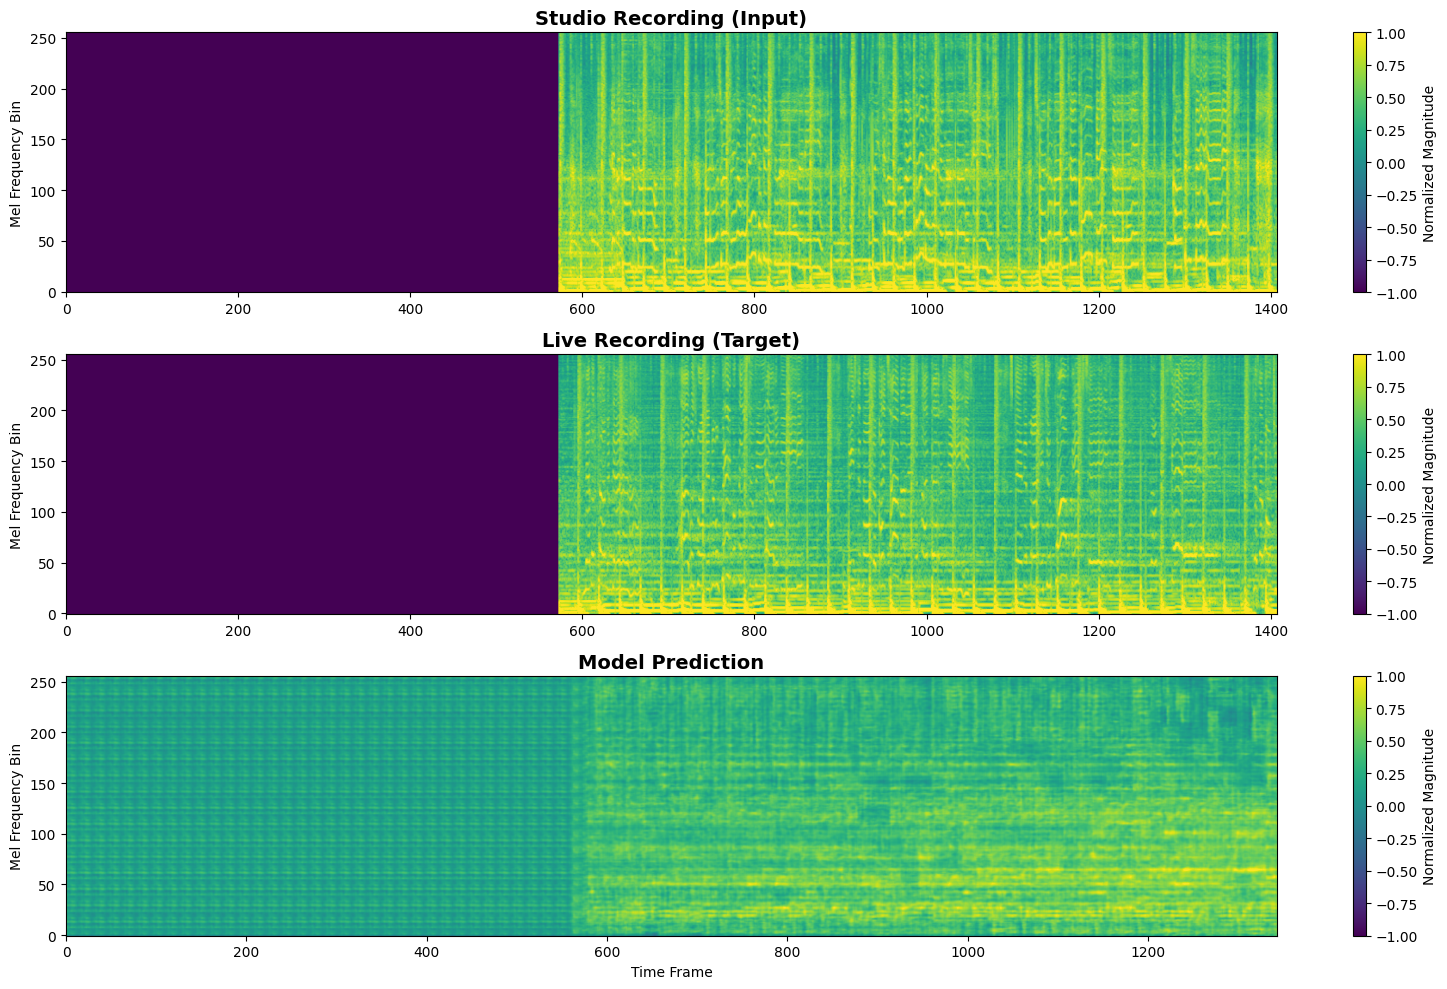

Spectrogram dimensions: 256 mel bins × 1408 time frames
Duration: 32.69 seconds


In [4]:
sample_idx = 0

studio_spec = studio_prepared[sample_idx, 0].cpu().numpy()  # (F, T)
live_spec = live_prepared[sample_idx, 0].cpu().numpy()
output_spec = output_prepared[sample_idx, 0].cpu().numpy()

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

im1 = axes[0].imshow(studio_spec, aspect='auto', origin='lower', cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Studio Recording (Input)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Mel Frequency Bin')
plt.colorbar(im1, ax=axes[0], label='Normalized Magnitude')

im2 = axes[1].imshow(live_spec, aspect='auto', origin='lower', cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Live Recording (Target)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Mel Frequency Bin')
plt.colorbar(im2, ax=axes[1], label='Normalized Magnitude')

im3 = axes[2].imshow(output_spec, aspect='auto', origin='lower', cmap='viridis', vmin=-1, vmax=1)
axes[2].set_title('Model Prediction', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Mel Frequency Bin')
axes[2].set_xlabel('Time Frame')
plt.colorbar(im3, ax=axes[2], label='Normalized Magnitude')

%matplotlib inline

plt.tight_layout()
plt.show()

print(f"Spectrogram dimensions: {studio_spec.shape[0]} mel bins × {studio_spec.shape[1]} time frames")
print(f"Duration: {studio_spec.shape[1] * 512 / SAMPLE_RATE:.2f} seconds")

## Convert to Audio and Listen

In [5]:
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
from concurrent.futures import as_completed
from tqdm.auto import tqdm

def _spec_to_db(normalized_spec):
    """Map normalized spectrogram [-1, 1] back to dB scale used by dataset."""
    db_min, db_max = -80.0, 20.0
    return ((normalized_spec + 1.0) / 2.0) * (db_max - db_min) + db_min


def _mel_db_to_audio_hq(spec_db, sr=SAMPLE_RATE, n_iter=128):
    """Higher-quality mel inversion via mel->STFT + Griffin-Lim."""
    spec_power = librosa.db_to_power(spec_db, ref=1.0)

    stft_mag = librosa.feature.inverse.mel_to_stft(
        spec_power,
        sr=sr,
        n_fft=2048,
        power=2.0,
        fmin=20,
        fmax=8000,
    )

    audio = librosa.griffinlim(
        stft_mag,
        n_iter=n_iter,
        hop_length=512,
        win_length=2048,
        window="hann",
        momentum=0.99,
        init="random",
    )

    peak = np.max(np.abs(audio))
    if peak > 1e-8:
        audio *= (0.95 / peak)

    return audio


def _process_spec(args):
    """Worker function."""
    normalized_spec, sr, n_iter = args
    spec_db = _spec_to_db(normalized_spec)
    return _mel_db_to_audio_hq(spec_db, sr=sr, n_iter=n_iter)


def process_all_specs_parallel(studio_spec, live_spec, output_spec, n_iter=32):
    """Process all spectrograms in parallel - NO segmentation."""
    n_workers = min(3, multiprocessing.cpu_count()) 
    
    specs = [
        (studio_spec, SAMPLE_RATE, n_iter),
        (live_spec, SAMPLE_RATE, n_iter),
        (output_spec, SAMPLE_RATE, n_iter)
    ]
    
    results = [None] * 3
    
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        with tqdm(total=3, desc="Processing spectrograms", unit="spec") as pbar:
            futures = {executor.submit(_process_spec, args): i for i, args in enumerate(specs)}
            
            for future in as_completed(futures):
                idx = futures[future]
                results[idx] = future.result()
                pbar.update(1)
    
    return results[0], results[1], results[2]


studio_audio, live_audio, output_audio = process_all_specs_parallel(studio_spec, live_spec, output_spec, n_iter=32)

print("🎵 Studio Recording (Input) - HQ inversion:")
display(Audio(studio_audio, rate=SAMPLE_RATE))

print("\n🎵 Live Recording (Target) - HQ inversion:")
display(Audio(live_audio, rate=SAMPLE_RATE))

print("\n🎵 Model Prediction - HQ inversion:")
display(Audio(output_audio, rate=SAMPLE_RATE))

rms_values = [np.sqrt(np.mean(a**2)) for a in (studio_audio, live_audio, output_audio)]
print(f"\n📊 Audio Statistics:")
print(f"  Duration: {len(studio_audio) / SAMPLE_RATE:.2f}s")
print(f"  Studio RMS: {rms_values[0]:.6f}")
print(f"  Live RMS: {rms_values[1]:.6f}")
print(f"  Prediction RMS: {rms_values[2]:.6f}")

Processing spectrograms: 100%|██████████| 3/3 [00:14<00:00,  4.92s/spec]

🎵 Studio Recording (Input) - HQ inversion:



🎵 Live Recording (Target) - HQ inversion:



🎵 Model Prediction - HQ inversion:



📊 Audio Statistics:
  Duration: 32.67s
  Studio RMS: 0.066999
  Live RMS: 0.091456
  Prediction RMS: 0.089202
